test文件用于测试和提交。
主要工作：  

（1）从chekcpoint文件夹内部读取指定的模型参数；  

（2）加载测试集数据；  

（3）在测试集上生成预测值；  

（4）按照kaggle上的要求生成相应的submission.csv文件   


请注意：这里PATH = './vgg16_adam_transforms3_epoch20.pth'，但是提交的代码包中并没有这个ckpt文件，所以如果要运行test文件，需要先执行main文件得到ckpt文件后才可以生成submission文件，不然会报错的。

In [10]:
import numpy as np
import pandas as pd

import torch
import torchvision
from torch.utils import data
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import os
import matplotlib
import matplotlib.pyplot as plt
from tensorboardX import SummaryWriter
import re

from tensorboardX import SummaryWriter

确认设备可用

In [2]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(device)

cuda:1


定义数据集，用于加载和读取数据
并且定义了基本的transform函数，用于图片的基本格式转换，方便加载到模型中去

In [3]:
class MyDataset(data.Dataset):
    def __init__(self, imgroot, csvroot=None, transform=None):
        filenames = os.listdir(imgroot)
        
        imgs = []
        for k in filenames:
            if re.match('.*\.jpg$', k):
                imgs.append(k)
        imgs.sort(key=lambda k:int(k[:-4]))
        # print(imgs)
        
        self.imgs = [os.path.join(imgroot, k) for k in imgs]
        # print(self.imgs)
        
        self.transforms = transform
        if csvroot:
            csv = pd.read_csv(csvroot)
            csv.info()
            # print(csv[:10])
            self.split = 'train'
            self.Y = csv['Category'].tolist()
            
        else:
            self.split = 'test'
               
    def __getitem__(self, index):
        img_path = self.imgs[index]
        try:
            pil_img = Image.open(img_path)
        except OSError:
            raise RuntimeError("couldn't read imge " + img_path)
        if self.transforms:
            img = self.transforms(pil_img)
        else:
            img = torch.from_numpy(np.asarray(pil_img))
        if self.split == 'train':
            y = self.Y[index]
            return img, y
        else:
            return img
    
    def __len__(self):
        return len(self.imgs)

transform = transforms.Compose(
                [transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

定义测试数据集，并且展示一部分测试图片，便于判断是否代码出错

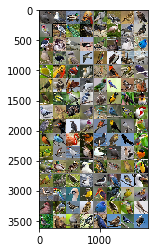

In [11]:
testset = MyDataset(
    './input/test/test',
    None,
    transform)
testloader = data.DataLoader(testset, batch_size = 128,
                            shuffle = False, num_workers = 4)
testiter = iter(testloader)

def imshow(img):
    img = img/2 + 0.5
    plt.imshow(np.transpose(img.numpy(), (1,2,0)))
    plt.show()
    
imgs = testiter.next()
img_grid = torchvision.utils.make_grid(imgs)
imgs.shape
imshow(img_grid)

加载模型和参数


In [4]:
vgg16 = torchvision.models.vgg16(pretrained=False)

num_classes = 180
feature_extract = True

vgg16.classifier[6] = nn.Sequential(
                          nn.Linear(4096, 1024), 
                          nn.ReLU(), 
                          nn.Dropout(0.4),
                          nn.Linear(1024, num_classes),                   
                          nn.LogSoftmax(dim=1))

model = vgg16


# PATH = './vgg16_feature_extract_adam_3.pth'
PATH = './vgg16_adam_transforms3_epoch20.pth'
model.load_state_dict(torch.load(PATH))


在测试集上执行模型

In [15]:
imgs = imgs.to(device)

In [7]:
total_pred = torch.LongTensor().to(device)
model.to(device)
model.eval()
with torch.no_grad():
    for imgs in testloader:
        imgs = imgs.to(device)
            
        outputs = model(imgs)
        _, prediction = torch.max(outputs.data, 1)
        # print(prediction)
        
        total_pred = torch.cat((total_pred, prediction), dim=0)
        

生成submission.csv文件

In [8]:
total_pred = total_pred.cpu()
idlist = ['%05d' % x for x in np.arange(len(total_pred))]
out_df = pd.DataFrame(np.c_[idlist, total_pred.numpy()], 
                      columns=['ID', 'Category'])
out_df.head()

out_df.to_csv('submission_vgg16_adam_transforms3_epoch20.csv', index=False)